In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn import datasets
from sklearn.model_selection import train_test_split
%matplotlib inline

In [13]:
classes = datasets.make_classification(n_samples = 100, n_features=3, n_informative=2,n_redundant=0, 
                                       n_classes=2, random_state=42)

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

class logistic_regression:
    def __init__(self, n_iterations=1000, eta=0.05):
        self.n_iterations = 1000
        self.eta = eta

    @staticmethod
    def log_grad(w, c, X, target):
        m = X.shape[0]
        y = (2 * target - 1)
        score = np.dot(X, w.T).flatten()
        Z = -y / (m * (1 + np.exp(y * score)))
        grad = Z[np.newaxis, :].dot(X)
        return grad / m, np.sum(Z) / m

    @classmethod
    def optimize(cls, w, c, X, y, n_iterations, eta):
        for i in range(n_iterations):
            grad_w, grad_c = cls.log_grad(w, c, X, y)
            w = w - eta * grad_w
            c = c - eta * grad_c
        return w, c

    def fit(self, X, y):
        self.X = X
        self.y_true = y
        w0 = np.zeros((1, X.shape[1]))
        c0 = 0
        self.w, self.c = self.optimize(w0, c0, X, y, self.n_iterations, self.eta)

    def predict_proba(self, X):
        score = X.dot(self.w.T).flatten() + self.c
        self.score = score
        return 1 / (1 + np.exp(-score))

    def predict(self, X, thr=0.5):
        proba = self.predict_proba(X)
        y_predicted = np.zeros(proba.shape, dtype=bool)
        y_predicted[proba > thr] = 1
        y_predicted[proba <= thr] = 0
        self.y_predicted = y_predicted
        return y_predicted
         
    def make_auc(self,X, thr, auc = 0):
        y_pred = self.predict(X,thr = thr)
        score_sort = np.sort(self.score)
        targets = np.where(y_pred == True, 1, 0)
        order = np.argsort(score_sort)
        targets = targets[order]
        num_pos=np.sum(targets)
        num_neg=len(targets)-num_pos
        """
        Вот тут я избегаю деления на 0, ибо на сгенерированных данных при определеных значениях вероятности 
        кол-во позитивных/негативных результатов обращаются в ноль.
        А так у TPR/FPR имеются хоть какие-то малые значения, мы можем вычислить площадь и построить график
        """
        TPR=np.concatenate([[0], np.cumsum(1-targets)/(num_neg + 0.000001)])
        FPR=np.concatenate([[0], np.cumsum(targets)/(num_pos + 0.000001)])
        if auc == 0:
            AUC_ROC = np.trapz(TPR, x = FPR, dx=0.1)
            plt.title('ROC curve')
            plt.ylim(0, 1.05)
            plt.xlabel('FPR')
            plt.ylabel('TPR')
            plt.grid()
            plt.legend(' ', title=f'AUC-ROC={AUC_ROC:.3f}')
            plt.plot(FPR, TPR)
        if auc == 1:
            precision=np.cumsum(1-targets)/(np.cumsum(1-targets)+np.cumsum(targets))
            recall = TPR
            AUC_PR = np.sum(precision*(TPR[1:]-TPR[:-1]))
            plt.title('PR curve')
            plt.ylim(0, 1.05)
            plt.xlabel('recall')
            plt.ylabel('presision')
            plt.grid()
            plt.legend(' ', title=f'AUC-PR={AUC_PR:.3f}')
            plt.plot(recall[1:], precision)
            
    def confusion_matrix(self,X,y,thr):
        y_pred = self.predict(X,thr = thr)
        predicted = np.where(y_pred == True, 1, 0)
        TP=np.sum(np.logical_and(predicted==1, y==1))
        FP=np.sum(np.logical_and(predicted==1, y==0))
        FN=np.sum(np.logical_and(predicted==0, y==1))
        TN=np.sum(np.logical_and(predicted==0, y==0))
        return pd.DataFrame(data = [[TP,FP],[FN,TN]], columns = ['0','1'])
            
        
        

In [15]:
X_train,X_test,y_train,y_test = train_test_split(classes[0], classes[1], shuffle = True, test_size = 0.3, random_state = 42)

In [16]:
model=logistic_regression()
model.fit(X_train, y_train)
y_predicted_test = model.predict(X_test)

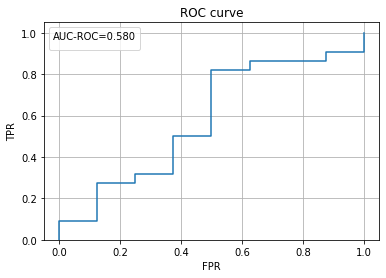

In [17]:
model.make_auc(X_test,thr=0.6, auc = 0)

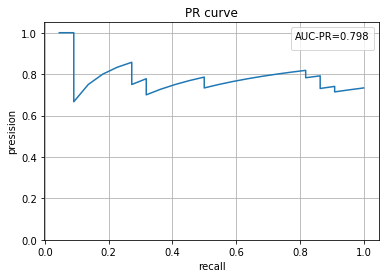

In [18]:
model.make_auc(X_test,thr = 0.6, auc =1)

In [19]:
model.confusion_matrix(X_test,y_test,thr=0.6)

,0,1
0,8,0
1,11,11
